# Guassian mixture intra-song clustering for identification of "main" beats

Code for doing tests

In [23]:
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import math
import librosa

from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.decomposition import PCA

from groove.downbeats import get_measures, get_beat_frames, smooth_power, beat_peaks, get_beat_data, get_audio_data, get_downbeats
from groove.embedding import bar_embedding, load_bar_embedding, load_bar_embedding_total, bar_embedding_total, segmented_smooth_power
from groove.intraclustering import get_ellipse_patch, get_patches, winnow_gm_components, ellipse_contains_points, find_closest_indices


def get_groove_type(key: str):
    return key.split('_')[1].split('/')[0]

def get_reduced_groove_type(key: str):
    return key.split('_')[1].split('/')[0].split('-')[0]



# Some settings
DROP_FILL = True
REDUCED_CATEGORIES = True
REPROCESS = False
SAVE_PROCESSED = False

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Load the file and process data using the embedding

In [9]:
import pickle as pkl


if REPROCESS:
    with open("data/groovemidi_beatnet_data.pkl","rb") as f:
        bn_data = pkl.load(f)

    print(f"{len(bn_data.keys())} groove samples loaded.")

    divs = np.array([3, 4, 6, 8, 9, 12, 16])
    wts = 1/np.sqrt(divs)

    data = {}

    for key in bn_data:
        if DROP_FILL and 'fill' in key:
            print(f"Dropped {key}")
            continue
        
        y, sr = librosa.load(f'{key}.wav')
        proc = segmented_smooth_power(y, sr)
        beat_data = bn_data[key]
        db = beat_data[beat_data[:,1] == 1, 0]

        # Some of the tracks are very short; skip them
        if db.shape[0] < 2:
            continue
        embeds = bar_embedding_total(proc, db, divs, sr, kernel_width=30)

        for i, e in enumerate(embeds):
            embeds[i] = embeds[i] * wts[i]
            embeds[i] = embeds[i].reshape(e.shape[0], -1)

        data[key] = np.concatenate(embeds, axis=1)

    print(f"{len(list(data))} samples processed.")
    if SAVE_PROCESSED:
        with open("data/groovemidi_beatnet_processed_data.pkl","wb+") as f:
            pkl.dump(data, f)
            print("Saved processed data.")

else:
    with open("data/groovemidi_beatnet_processed_data.pkl", "rb") as f:
        data = pkl.load(f)
        print(f"Loaded {len(data.keys())} samples of processed data.")

Loaded 396 samples of processed data.


['afrobeat', 'afrocuban', 'blues', 'country', 'dance', 'funk', 'gospel', 'highlife', 'hiphop', 'jazz', 'latin', 'middleeastern', 'neworleans', 'pop', 'punk', 'reggae', 'rock', 'session', 'soul']


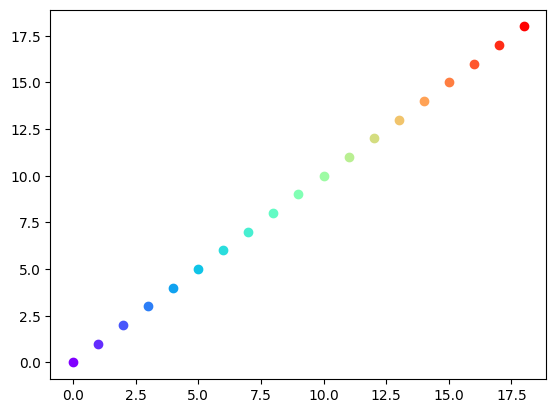

In [10]:
groove_names = set()
for key in bn_data:
    if REDUCED_CATEGORIES:
        groove_names.add(get_reduced_groove_type(key))
    else:
        groove_names.add(get_groove_type(key))
groove_names = list(groove_names)
groove_names.sort()

groove_colors = mpl.colormaps['rainbow'](np.linspace(0, 1, len(groove_names)))
#plt.cm.get_cmap('hsv', len(groove_names))

for i in range(len(groove_names)):
    plt.scatter([i], [i], color=groove_colors[i])

print(groove_names)



In [13]:
from groove.intraclustering import get_primary_gaussian_mean


if REPROCESS:
    keys = []
    measures = []
    name_indices = []

    for key in data:
        keys.append(key)
        embed = data[key]
        measures.append(get_primary_gaussian_mean(embed))
        if REDUCED_CATEGORIES:
            groove_name = get_reduced_groove_type(key)
        else:
            groove_name = get_groove_type(key)
        name_indices.append(groove_names.index(groove_name))
        
    print(f"Processed {len(measures)} data.")

    if SAVE_PROCESSED:
        with open("data/groovemidi_beatnet_measure_data.pkl","wb+") as f:
            pkl.dump({'keys': np.array(keys), 'measures': np.stack(measures), 'name_indices': np.array(name_indices), 'groove_names': groove_names}, f)
            print("Saved.")
else:
    with open("data/groovemidi_beatnet_measure_data.pkl", "rb") as f:
        temp = pkl.load(f)
        keys = temp['keys']
        measures = temp['measures']
        name_indices = temp['name_indices']
        print("Loaded.")

Processed 396 data.
Saved.


In [20]:
INCLUDE = False
INCLUDE_INDICES = [groove_names.index('rock'), groove_names.index('funk')]
EXCLUDE_INDICES = []

name_indices = np.array(name_indices)
measures = np.stack(measures)
keys = np.array(keys)

if INCLUDE:
    inds = np.full(name_indices.shape, False)
    for i in INCLUDE_INDICES:
        inds = inds | (name_indices == i)
else:
    inds = np.full(name_indices.shape, True)
    for i in EXCLUDE_INDICES:
        inds = inds & (name_indices != i)

mdata = measures[inds]
ndata = name_indices[inds]
kdata = keys[inds]


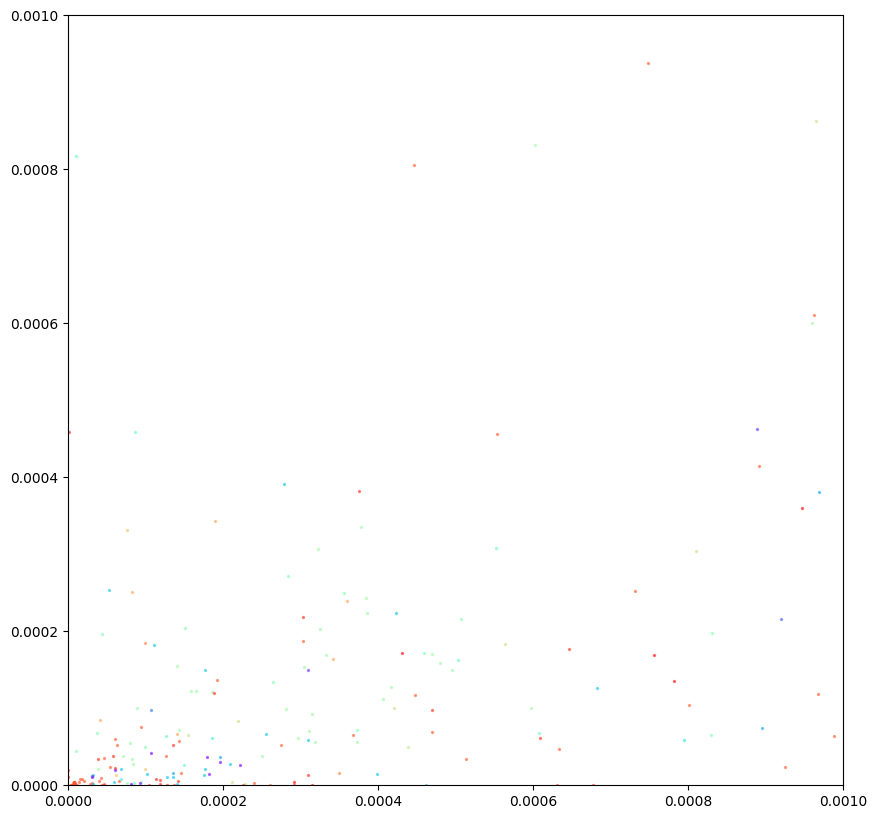

In [22]:
pca = PCA(n_components=2)
pca.fit(mdata)
red_measures = pca.transform(mdata)

plt.figure(figsize=(10,10))
ax = plt.gca()
ax.set_xlim([0, .001])
ax.set_ylim([0, .001])

for i in range(len(mdata)):
        plt.scatter(mdata[i,0], mdata[i,1], color=groove_colors[ndata[i]], alpha=0.5, s=2)

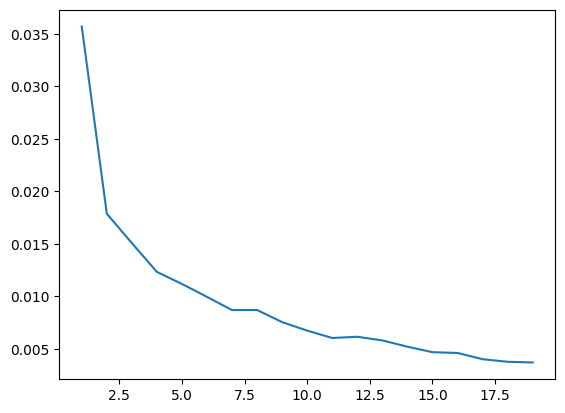

In [16]:
from sklearn.cluster import KMeans

errors = []

for i in range(1, len(groove_names) + 1, 1):
    km = KMeans(n_clusters=i)
    km.fit(mdata)
    errors.append(km.inertia_)


plt.plot(range(1, len(groove_names) + 1, 1), errors)

In [17]:
NUM_CLUSTERS = 2

km = KMeans(n_clusters=NUM_CLUSTERS)
km.fit(mdata)

preds = km.predict(mdata)

pred_dict = {}

for i in range(NUM_CLUSTERS):
    pred_dict[i] = []

for i in range(preds.shape[0]):
    pred_dict[preds[i].item()].append(kdata[i])

In [18]:
pred_dict_cats = {}


for i in range(NUM_CLUSTERS):
    pred_dict_cats[i] = []

for i in range(preds.shape[0]):
    pred_dict_cats[preds[i].item()].append(groove_names[ndata[i]])

for i in range(NUM_CLUSTERS):
    pred_dict_cats[i].sort()

In [19]:
pred_dict_cats

{0: ['funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'funk',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock',
  'rock

# Ten rock and ten hiphop

In [6]:
rock_list = ['01 - Burnout', '03-dropkick_murphys-the_state_of_massachusetts', '05 - Kids', '02 - Another One Bites the Dust', ('02 - The Offspring - Have You Ever', 'm4a'), '13 - Baba O\'Riley', "02 Guns N Roses - Sweet Child O' Mine", '01-The Pretender', 'Bruce Springsteen - Born in the USA', 'The Red Hot Chili Peppers - Can\'t Stop']
hiphop_list = [('08 HUMBLE', 'm4a'), "Nas - Memory Lane (Sittin' In Da Park)", '02 Bow Down', ('11 Everyday Struggle', 'm4a'), '01 Run The Jewels', ('08. N.W.A - Express Yourself', 'flac'), '05 - The Beast', '1-13 Potholes in My Lawn', '02 - Big Daddy Kane - Set It Off', '10 Mastermind']

len(rock_list), len(hiphop_list)

(10, 10)

In [7]:
import numpy as np
from groove.embedding import load_bar_embedding_total, segmented_smooth_power
from groove.intraclustering import get_primary_gaussian_mean


divs = np.array([3, 4, 6, 8, 9, 12, 15, 16, 18, 20, 21, 24])
wts = 1/np.sqrt(divs)

# Add extension
for list in (rock_list, hiphop_list):
    for i in range(len(list)):
        if type(list[i]) is not tuple:
            list[i] = (list[i], "mp3")

rock_means = []
for i, (file, ext) in enumerate(rock_list):
    data = load_bar_embedding_total(file, divs, wts, segmented_smooth_power, ext=ext, concatenate=True)
    rock_means.append(get_primary_gaussian_mean(data))
rock_means = np.array(rock_means)

hiphop_means = []
for i, (file, ext) in enumerate(hiphop_list):
    data = load_bar_embedding_total(file, divs, wts, segmented_smooth_power, ext=ext, concatenate=True)
    hiphop_means.append(get_primary_gaussian_mean(data))
hiphop_means = np.array(hiphop_means)

[src/libmpg123/id3.c:process_comment():584] error: No comment text / valid description?
Note: Illegal Audio-MPEG-Header 0x65656e20 at offset 2036467.
Note: Trying to resync...
Note: Hit end of (available) data during resync.
/home/harrison/erdos/groove_gang/groove/embedding.py:303: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(f'inputs/{file}.{ext}')
/home/harrison/erdos/groove_gang/venv/lib/python3.12/site-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
[src/libmpg123/id3.c:process_extra():681] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():681] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():681] error: No extra frame text / valid description?
[src/libmpg123/id3.c:process_extra():681] err

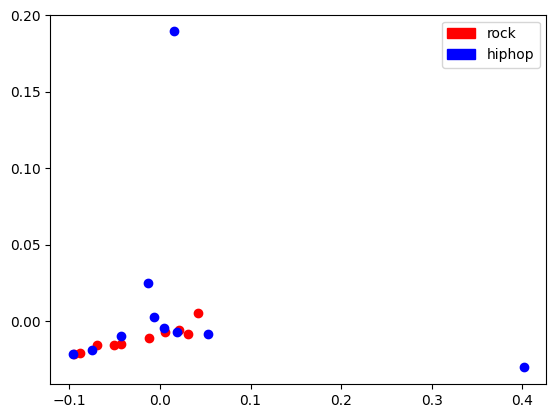

In [ ]:
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

all_means = np.concatenate([rock_means, hiphop_means], axis=0)

pca = PCA(n_components=2)
pca.fit(all_means)
red_means = pca.transform(all_means)


lpatches = [mpatches.Patch(color='red', label='rock'), mpatches.Patch(color='blue', label='hiphop')]

for i in range(len(rock_list)):
    plt.scatter(red_means[i,0], red_means[i,1], color='red')
for i in range(len(hiphop_list)):
    plt.scatter(red_means[i + 10,0], red_means[i + 10,1], color='blue')


plt.legend(handles=lpatches)

In [29]:
from sklearn.cluster import KMeans

NUM_CLUSTERS = 2

km = KMeans(n_clusters=NUM_CLUSTERS)
km.fit(all_means)

preds = km.predict(all_means)

pred_dict = {}
pred_inds = {}

for i in range(NUM_CLUSTERS):
    pred_dict[i] = []
    pred_inds[i] = []

for i in range(preds.shape[0]):
    pred_dict[preds[i].item()].append(all_means[i])
    pred_inds[preds[i].item()].append(i < 10)

In [30]:
pred_inds

{0: [True, True, True, True, True, True, False, False, False],
 1: [True, True, True, True, False, False, False, False, False, False, False]}